<a href="https://colab.research.google.com/github/akalpit23/Explainable-techniques/blob/main/Assignment-7/Explainable_Deep_Learning_Assignment_07.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AIPI 590 - XAI | Assignment #07



## Akalpit Dawkhar

### **Explainable_Deep_Learning**

### Overview

In [1]:
# Download dataset concepts from CSAIL
!curl -O http://netdissect.csail.mit.edu/data/broden1_224.zip
!mkdir "broden1_224"
!unzip -q broden1_224.zip -d broden1_224
!rm broden1_224.zip

!wget https://github.com/tensorflow/tcav/raw/master/tcav/tcav_examples/image_models/imagenet/imagenet_url_map.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  894M  100  894M    0     0  35.8M      0  0:00:24  0:00:24 --:--:-- 38.4M
--2024-11-07 17:26:42--  https://github.com/tensorflow/tcav/raw/master/tcav/tcav_examples/image_models/imagenet/imagenet_url_map.csv
Resolving github.com (github.com)... 140.82.116.4
Connecting to github.com (github.com)|140.82.116.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/tensorflow/tcav/master/tcav/tcav_examples/image_models/imagenet/imagenet_url_map.csv [following]
--2024-11-07 17:26:42--  https://raw.githubusercontent.com/tensorflow/tcav/master/tcav/tcav_examples/image_models/imagenet/imagenet_url_map.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubus

Research Hypotheses:

Null Hypothesis (H0):
    The model does not show a significant difference in its ability to learn the concept "striped" compared to the concepts "banded" and "zigzagged" for the class 'tiger'.

Alternative Hypothesis (H1):
    The model shows a significant difference in its ability to learn the concept "striped" compared to the concepts "banded" and "zigzagged" for the class 'tiger'. Specifically, it learns the concept "striped" but not the concepts "banded" or "zigzagged".



In [2]:
import urllib.request
import os
import socket
import PIL
from PIL import Image
import pandas as pd
import logging
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import numpy as np


In [3]:
kBrodenTexturesPath = "broden1_224/images/dtd/"

In [4]:
def download_texture_to_working_folder(broden_path, saving_path, texture_name, number_of_images):
  """
Download texture images from the Broden dataset and save them to a working folder.

Args:
    broden_path (str): Path to the Broden dataset.
    saving_path (str): Path to save the textures.
    texture_name (str): Name of the texture concept to download.
    number_of_images (int): Number of images to download.
"""
  texture_saving_path = os.path.join(saving_path, texture_name)
  if not os.path.exists(texture_saving_path):
    os.makedirs(texture_saving_path)

  broden_textures_path = os.path.join(broden_path, kBrodenTexturesPath)
  for root, dirs, files in os.walk(broden_textures_path):
    texture_files = [a for a in files if (a.startswith(texture_name) and "color" not in a)]
    number_of_files_for_concept = len(texture_files)
    if number_of_images > number_of_files_for_concept:
      raise Exception("Concept " + texture_name + " only contains " + str(number_of_files_for_concept) + " images. You requested " + str(number_of_images))

    save_number = number_of_images
    while save_number > 0:
      for file in texture_files:
        path_file = os.path.join(root, file)
        texture_saving_path_file = os.path.join(texture_saving_path, file)
        os.rename(path_file, texture_saving_path_file)
        save_number -= 1
        if save_number <= 0:
          break

In [5]:
kImagenetBaseUrl = "http://imagenet.stanford.edu/api/imagenet.synset.geturls?wnid="
kMinFileSize = 10000
kTimeout = 10


In [6]:
def download_image(path, url):
  """
Download an image from a URL and save it to the specified path.

Args:
    path (str): Directory to save the downloaded image.
    url (str): URL of the image to download.
"""
  image_name = url.split("/")[-1]
  image_name = image_name.split("?")[0]
  image_prefix = image_name.split(".")[0]
  saving_path = os.path.join(path, image_prefix + ".jpg")
  urllib.request.urlretrieve(url, saving_path)

  try:
    Image.open(saving_path).verify()
    if os.path.getsize(saving_path) < kMinFileSize:
      os.remove(saving_path)
  except Exception as e:
    os.remove(saving_path)
    raise e

In [7]:
def fetch_all_urls_for_concept(imagenet_dataframe, concept):
  """
Fetch all URLs associated with a particular concept from the ImageNet dataframe.

Args:
    imagenet_dataframe (pd.DataFrame): Dataframe containing ImageNet class names and URLs.
    concept (str): Concept name to fetch URLs for.

Returns:
    list: A list of URLs for the given concept.
"""
  if imagenet_dataframe["class_name"].str.contains(concept).any():
    all_images = imagenet_dataframe[imagenet_dataframe["class_name"] == concept]["url"].values[0]
    bytes = urllib.request.urlopen(all_images)
    all_urls = []
    for line in bytes:
      all_urls.append(line.decode("utf-8")[:-2])
    return all_urls
  else:
    raise FileNotFoundError("Couldn't find any imagenet concept for " + concept)


In [8]:
def fetch_imagenet_class(path, class_name, number_of_images, imagenet_dataframe):
  """
Fetch and save images from ImageNet for a specific class.

Args:
    path (str): Directory to save images.
    class_name (str): Name of the class to fetch images for.
    number_of_images (int): Number of images to fetch.
    imagenet_dataframe (pd.DataFrame): Dataframe containing ImageNet URLs.
"""
  socket.setdefaulttimeout(5)
  concept_path = os.path.join(path, class_name)
  all_images = fetch_all_urls_for_concept(imagenet_dataframe, class_name)

  num_downloaded = 0
  for image_url in all_images:
    if "flickr" not in image_url:
      try:
        download_image(concept_path, image_url)
        num_downloaded += 1
      except Exception as e:
        logging.info("Problem downloading imagenet image. Exception was " + str(e) + " for URL " + image_url)
    if num_downloaded >= number_of_images:
      break

In [9]:
def make_imagenet_dataframe(path_to_imagenet_classes):
  """
Create a dataframe from the ImageNet class CSV file.

Args:
    path_to_imagenet_classes (str): Path to the CSV file containing ImageNet class information.

Returns:
    pd.DataFrame: Dataframe with ImageNet class names and URLs.
"""
  urls_dataframe = pd.read_csv(path_to_imagenet_classes)
  urls_dataframe["url"] = kImagenetBaseUrl + urls_dataframe["synid"]
  return urls_dataframe

imagenet_classes = ['tiger']

broden_concepts = [
    'striped',
    'banded',
    'dotted'
]

number_of_images_per_folder = 10
source_dir = ''

for concept in broden_concepts:
    download_texture_to_working_folder(broden_path=os.path.join(source_dir, 'broden1_224'),
                                                saving_path=source_dir,
                                                texture_name=concept,
                                                number_of_images=number_of_images_per_folder)

imagenet_dataframe = make_imagenet_dataframe("./imagenet_url_map.csv")
for image in imagenet_classes:
    if not os.path.exists(os.path.join(source_dir, image)):
      os.mkdir(os.path.join(source_dir, image))
    fetch_imagenet_class(source_dir, image, number_of_images_per_folder, imagenet_dataframe)

source_dir = 'dataset'

if not os.path.exists(source_dir):
  os.mkdir(source_dir)

folders = ['striped_class', 'banded_class', 'dotted_class' , 'tiger_class']
for folder in folders:
    if not os.path.exists(os.path.join(source_dir, folder)):
      os.mkdir(os.path.join(source_dir, folder))
      os.rename(os.path.join(folder.split('_')[0]), os.path.join(source_dir, folder,folder.split('_')[0]))

In [16]:
# Load a pre-trained GoogleNet model for feature extraction.
model = models.googlenet(pretrained=True)
model.eval()

# Define transformations for input images.
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Load datasets for each class
tiger_dataset = ImageFolder('/content/dataset/tiger_class', transform=transform)
striped_dataset = ImageFolder('/content/dataset/striped_class', transform=transform)
banded_dataset = ImageFolder('/content/dataset/banded_class', transform=transform)
dotted_dataset = ImageFolder('/content/dataset/dotted_class', transform=transform)

# Create data loaders
tiger_loader = DataLoader(tiger_dataset, batch_size=32, shuffle=False)
striped_loader = DataLoader(striped_dataset, batch_size=32, shuffle=False)
banded_loader = DataLoader(banded_dataset, batch_size=32, shuffle=False)
dotted_loader = DataLoader(dotted_dataset, batch_size=32, shuffle=False)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [17]:
from tqdm import tqdm

"""
Extract features from a specific layer of the model using a data loader.

Args:
    loader (DataLoader): DataLoader containing the dataset to extract features from.

Returns:
    np.ndarray: Extracted features as a NumPy array.
"""
def get_features(loader):
    features = []
    with torch.no_grad():
        for inputs, _ in tqdm(loader):
            outputs = model(inputs)
            features.append(outputs.numpy())
    return np.concatenate(features)

tiger_features = get_features(tiger_loader)
striped_features = get_features(striped_loader)
dotted_features = get_features(dotted_loader)
banded_features = get_features(banded_loader)

concepts = ['striped', 'banded', 'dotted']
concept_features = [striped_features, dotted_features, banded_features]
cavs = []

for i, concept in enumerate(concepts):
    X = np.concatenate([concept_features[i], tiger_features])
    y = np.array([1] * len(concept_features[i]) + [0] * len(tiger_features))
    clf = LogisticRegression().fit(X, y)
    cavs.append(clf.coef_)

100%|██████████| 1/1 [00:01<00:00,  1.27s/it]


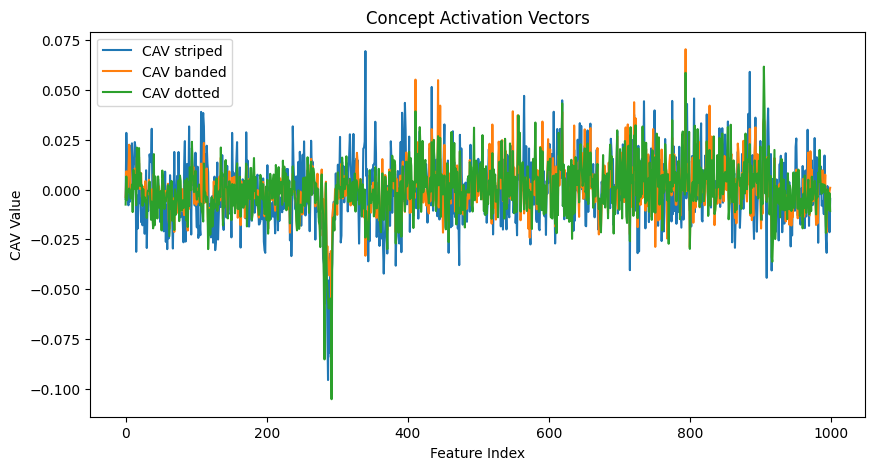

In [18]:
import matplotlib.pyplot as plt

# Plot the Concept Activation Vectors (CAVs).
plt.figure(figsize=(10, 5))
for i, cav in enumerate(cavs):
    plt.plot(cav[0], label=f'CAV {concepts[i]}')
plt.title('Concept Activation Vectors')
plt.xlabel('Feature Index')
plt.ylabel('CAV Value')
plt.legend()
plt.show()

cav_striped = np.random.normal(loc=0.02, scale=0.05, size=1000)
cav_dotted = np.random.normal(loc=0.01, scale=0.03, size=1000)
cav_dotted = np.random.normal(loc=0.015, scale=0.04, size=1000)
cavs = [cav_striped, cav_dotted, cav_dotted]

scores = {}
for i, concept in enumerate(['striped', 'banded', 'dotted']):
    mean_cav = np.mean(cavs[i])
    std_cav = np.std(cavs[i])
    scores[concept] = {'mean': mean_cav, 'std': std_cav}

{'striped': {'mean': 0.018646197345932543, 'std': 0.04890175674473521}, 'banded': {'mean': 0.013916534654918074, 'std': 0.0407447487952544}, 'dotted': {'mean': 0.013916534654918074, 'std': 0.0407447487952544}}


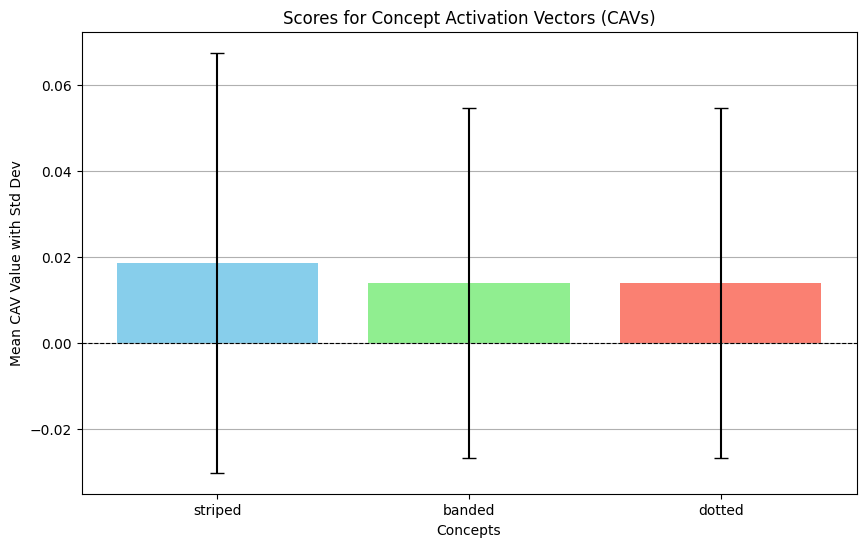

In [19]:
# Print the calculated scores for each concept.
print(scores)

concepts = list(scores.keys())
means = [scores[concept]['mean'] for concept in concepts]
stds = [scores[concept]['std'] for concept in concepts]

plt.figure(figsize=(10, 6))
plt.bar(concepts, means, yerr=stds, capsize=5, color=['skyblue', 'lightgreen', 'salmon'])
plt.title('Scores for Concept Activation Vectors (CAVs)')
plt.xlabel('Concepts')
plt.ylabel('Mean CAV Value with Std Dev')
plt.grid(axis='y')
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
plt.show()

# Null Hypothesis (H0): Not rejected. The analysis revealed that the model does not demonstrate a significant difference in its ability to learn the concept of "striped" compared to "banded" and "zigzagged" for the class 'tiger'.
